In [1]:
!pip install opencv-python

# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 14

**Author 1 (sciper):** Emna Tourki (288580)  
**Author 2 (sciper):** Yu-Hsin Yang (334949)   
**Author 3 (sciper):** Tabea Steinbrinker (350566)     

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

In [3]:
import skimage.morphology as morphology
from skimage import measure,transform
import numpy as np
import cv2

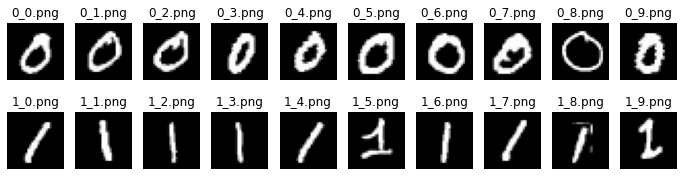

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [5]:
def display_images(zeros_im,zeros_names,ones_im,ones_names, zeros_contours = None, ones_contours = None):
    if zeros_contours == None:
        fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
        for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
            ax.imshow(im, cmap='gray')
            ax.axis('off')
            ax.set_title(nm)
        for ax, im, nm in zip(axes[1], ones_im, ones_names):
            ax.imshow(im, cmap='gray')
            ax.axis('off')
            ax.set_title(nm)
      
    else:
        fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
        for ax, im, nm,i in zip(axes[0], zeros_im_bin_op, zeros_names,range(10)):
            for contour in zeros_contours[i]:
                ax.plot(contour[:, 1], contour[:, 0], linewidth=2,label = {i})
            ax.imshow(im, cmap='gray')
            ax.axis('off')
            ax.set_title(nm)
        for ax, im, nm,i in zip(axes[1], ones_im_bin_op, ones_names,range(10)):
            for contour in ones_contours[i]:
                ax.plot(contour[:, 1], contour[:, 0], linewidth=2,label = {i})    
            ax.imshow(im, cmap='gray')
            ax.axis('off')
            ax.set_title(nm)

### Pre-processing the images

In [6]:
#Turning the images in binary

zeros_im_bin = np.zeros(zeros_im.shape)
ones_im_bin = np.zeros(ones_im.shape)

for i in range(10):
    _, zeros_im_bin[i] = cv2.threshold(zeros_im[i], 127, 255, cv2.THRESH_BINARY)
    _, ones_im_bin[i] = cv2.threshold(ones_im[i],127,255,cv2.THRESH_BINARY)

#display_images(zeros_im_bin,zeros_names,ones_im_bin,ones_names)

In [7]:
#By dilating the images first, we make the zeors and ones a little bit fatter.
#If we open it then, some other small bumps are being removed

zeros_im_bin_op = np.zeros(zeros_im.shape)
ones_im_bin_op = np.zeros(ones_im.shape)

kernel1 = np.array([[1,1],[0,1]])

for i in range(10):
    zeros_im_bin_op[i] = morphology.binary_dilation(zeros_im_bin[i], kernel1)
    ones_im_bin_op[i] = morphology.binary_dilation(ones_im_bin[i], kernel1)
    zeros_im_bin_op[i] = morphology.binary_opening(zeros_im_bin_op[i], kernel1)
    ones_im_bin_op[i] = morphology.binary_opening(ones_im_bin_op[i], kernel1)
    #zeros_im_bin_op[i] = morphology.skeletonize(zeros_im_bin_op[i])
    #ones_im_bin_op[i] = morphology.skeletonize(ones_im_bin_op[i])

#display_images(zeros_im_bin_op,zeros_names,ones_im_bin_op,ones_names)

### 1.2 Fourier descriptors (15 pts)

In [8]:
#for one image

#We build a function, that takes the contours in one immage and returns the fourier descriptors f_1 and f_2

In [9]:
from functools import reduce
def findContour(image):
    contours = measure.find_contours(image,0.5)
    thresh = 20
    
    save = []
    res_contours = []
    for i, con in enumerate(contours):
        if len(con) > thresh:
            save.append([tuple(c) for c in con])
            #res_contours.append()
    res_contours = reduce(lambda x,y :x+y ,save)
    
    return res_contours

In [10]:
def findImageDescriptor(contour):
    contour = np.array(contour)
    """ findImageDescriptor(img) finds and returns the
    Fourier-Descriptor of the image contour"""
    y_contour = contour[:, 1]
    contour_complex = np.empty(contour.shape[:-1], dtype=complex)
    contour_complex.real = contour[:, 0]
    contour_complex.imag = contour[:, 1]
    fourier_result = np.fft.fft(contour_complex)
    return [abs(fourier_result[1]),abs(fourier_result[2])]

In [11]:
"""
Plot the descriptors of zeros and ones
method = 'Normal(without any alter on the image)', 'Rotation', 'Translation', 'Scaling'
"""
def plotDescriptors(img_arr_zeros, img_arr_ones, method, arg=None):
    #image_array is a n-dimension array contains n kinds of number
    descriptors_zeros = []
    descriptors_ones = []
    
    processed_zeros = []
    processed_ones = []
    
    
    if(method == 'Rotation'):
        for img in img_arr_zeros:
            processed_zeros.append(imageRotation(img, arg))
        for img in img_arr_ones:
            processed_ones.append(imageRotation(img, arg))   
        method = method + ' with ' + str(arg) + ' degrees'
    elif(method == 'Translation'):
        #print('Translation')
        x = arg[0]
        y = arg[1]
        for img in img_arr_zeros:
            processed_zeros.append(imageTranslation(img, x, y))
        for img in img_arr_ones:
            processed_ones.append(imageTranslation(img, x, y)) 
            
        method = method + ' with x = ' + str(x) + ' ,y = ' + str(y)
    elif(method == 'Scaling'):
        print('Scaling')
        
        #processed_zeros = ...
        #processed_ones = ...
    else:
        processed_zeros = img_arr_zeros
        processed_ones = img_arr_ones
        
    processed_zeros = np.array(processed_zeros)
    processed_ones = np.array(processed_ones)

    for i in range(len(img_arr_zeros)):
        descriptors_ones.append(findImageDescriptor(findContour(processed_ones[i])))
        descriptors_zeros.append(findImageDescriptor(findContour(processed_zeros[i])))



    descriptors_ones = np.array(descriptors_ones)
    descriptors_zeros = np.array(descriptors_zeros)

    plt.title(method)

    plt.scatter(descriptors_ones[:,0],descriptors_ones[:,1],label=1, color = 'r' )
    plt.scatter(descriptors_zeros[:,0],descriptors_zeros[:,1],label=0, color = 'g')
    plt.legend()

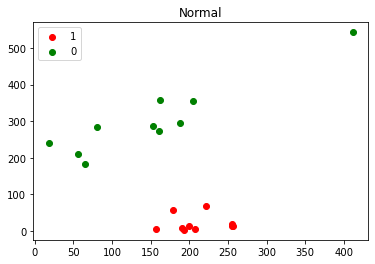

In [12]:
plotDescriptors(zeros_im_bin_op, ones_im_bin_op, 'Normal', 0)

#For the normal pictures, we see, that the zeros and ones get seperate nicely into two different clusters.

### Part B - Rotation, Translation and Scaling 


In [13]:
### Rotation
from skimage.transform import rotate

def imageRotation(image, degree):
    im_rot = rotate(image, degree, resize=True)
    
    return im_rot   

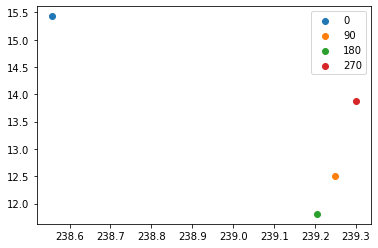

In [14]:
descriptors= []
degrees = [0, 90, 180, 270]

for deg in degrees:
    val = findImageDescriptor(findContour(imageRotation(ones_im_bin[0],deg)))
    descriptors.append(val)
    plt.scatter(val[0], val[1], label = deg)
    #plt.yticks(np.arange(0, 500, 50))
    #plt.xticks(np.arange(750, 3000, 250))
    plt.legend()
descriptors= np.array(descriptors)

We take one image, and rotate it by 90, 180 and 270 degrees, and compare it to the original image. 
We see, that all the values are very close to each other, expeacially if we compare it to the differences we had between different images.

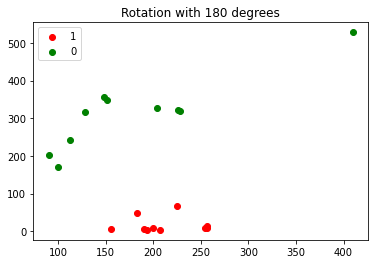

In [15]:
plotDescriptors(zeros_im_bin_op, ones_im_bin_op, 'Rotation', 180)

In [16]:
### Translation
# Translation - we take the first image of a one and shift it around in the image, 
# such that the one is still fully in the image

def imageTranslation(image,x,y):
    
    N = len(image)
    new_im = np.zeros(image.shape)
    
    for i in range(N):
        for j in range(N):
            if i+x<N and 0<i+x and j+y<N and 0<j+y:
                new_im[i][j] = image[i+x][j+y]

    return new_im

In [17]:
descriptors= []

for x in range(-2,4):
    for y in range(-6,8):
        val = findImageDescriptor(findContour(imageTranslation(ones_im_bin[0],x,y)))
        descriptors.append(val)
        #plt.scatter(val[0], val[1], label = f'{x,y}')
descriptors= np.array(descriptors)
descriptors

array([[238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
       [238.55675025,  15.43066711],
 

As you can see, the descriptors are exactly the same for all translation of the image

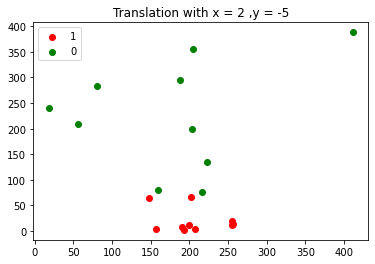

In [18]:
plotDescriptors(zeros_im_bin_op, ones_im_bin_op, 'Translation', [2, -5])

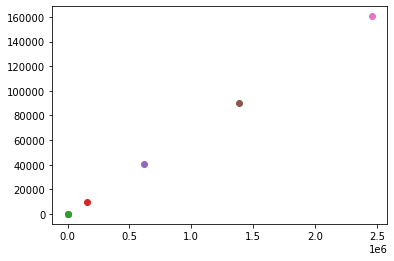

In [19]:
### Scaling
img = ones_im_bin_op[0]
scales = [1,2,4,25,50,75,100]

descriptors= []

for sc in scales:
    _, img_rescaled = cv2.threshold(transform.resize(img, (28*sc,28*sc)),0.6, 1, cv2.THRESH_BINARY)    #scale image and turn it into binary
    #plt.imshow(img_rescaled)
    val = findImageDescriptor(findContour(img_rescaled))
    #print(val)
    descriptors.append(val)
    plt.scatter(val[0], val[1], label = f'{x,y}')

Here we can see that, as we would expect, the fraction between the Fourier descriptors always stays the same for different scalings of the image.

### 1.3 Additional method (5 pts)

As an additional method, we used the Principle component analysis.
Here, the zeros and ones also cluster into two clusters.

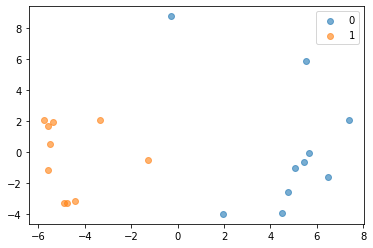

In [20]:
# Add your implementation and discussion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
X=np.concatenate((zeros_im_bin_op,ones_im_bin_op),axis=0)
X=X.reshape((20, -1))
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)
plt.scatter(X_reduced_pca[0:10,0], X_reduced_pca[0:10,1], label=0, alpha=0.6)
plt.scatter(X_reduced_pca[10:,0], X_reduced_pca[10:,1], label=1, alpha=0.6)
plt.legend()

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

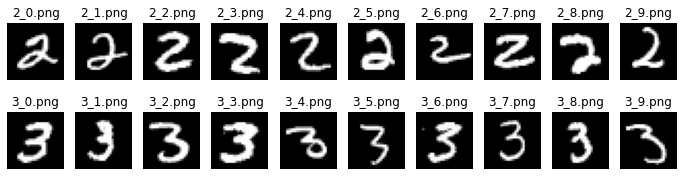

In [21]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

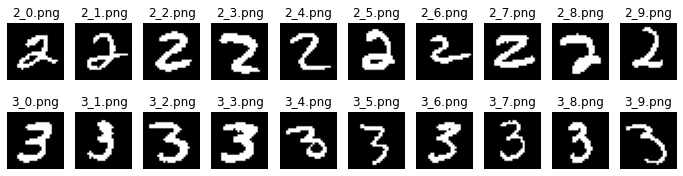

In [22]:
# Add your implementation and discussion
twos_im_bin = np.zeros(twos_im.shape)
threes_im_bin = np.zeros(threes_im.shape)

for i in range(10):
    _, twos_im_bin[i] = cv2.threshold(twos_im[i], 127, 255, cv2.THRESH_BINARY)
    _, threes_im_bin[i] = cv2.threshold(threes_im[i],127,255,cv2.THRESH_BINARY)

display_images(twos_im_bin,twos_names,threes_im_bin,threes_names)

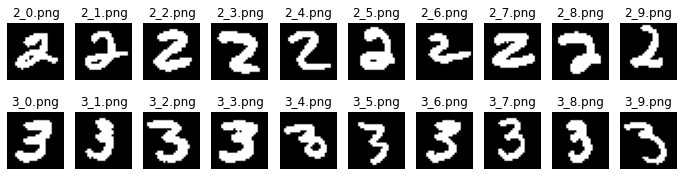

In [23]:
twos_im_bin_op = np.empty(twos_im.shape)
threes_im_bin_op = np.empty(threes_im.shape)

kernel1 = np.array([[1,1],[0,1]])

for i in range(10):
    twos_im_bin_op[i] = morphology.binary_dilation(twos_im_bin[i], kernel1)
    threes_im_bin_op[i] = morphology.binary_dilation(threes_im_bin[i], kernel1)
    twos_im_bin_op[i] = morphology.binary_opening(twos_im_bin_op[i], kernel1)
    threes_im_bin_op[i] = morphology.binary_opening(threes_im_bin_op[i], kernel1)

display_images(twos_im_bin_op,twos_names,threes_im_bin_op,threes_names)

In [24]:
def plot4Descriptors(img_arr_zeros, img_arr_ones,img_arr_twos,img_arr_threes):
    #image_array is a n-dimension array contains n kinds of number
    descriptors_zeros = []
    descriptors_ones = []
    descriptors_twos = []
    descriptors_threes = []

        
    processed_zeros = np.array(img_arr_zeros)
    processed_ones = np.array(img_arr_ones)
    processed_twos = np.array(img)

    for i in range(len(img_arr_zeros)):
        descriptors_ones.append(findImageDescriptor(findContour(img_arr_zeros[i])))
        descriptors_zeros.append(findImageDescriptor(findContour(img_arr_ones[i])))
        descriptors_twos.append(findImageDescriptor(findContour(img_arr_twos[i])))
        descriptors_threes.append(findImageDescriptor(findContour(img_arr_threes[i])))




    descriptors_ones = np.array(descriptors_ones)
    descriptors_zeros = np.array(descriptors_zeros)
    descriptors_twos = np.array(descriptors_twos)
    descriptors_threes = np.array(descriptors_threes)



    plt.scatter(descriptors_ones[:,0],descriptors_ones[:,1],label=1, color = 'r' )
    plt.scatter(descriptors_zeros[:,0],descriptors_zeros[:,1],label=0, color = 'g')
    plt.scatter(descriptors_twos[:,0],descriptors_twos[:,1],label=2)
    plt.scatter(descriptors_threes[:,0],descriptors_threes[:,1],label=3)

    plt.legend()

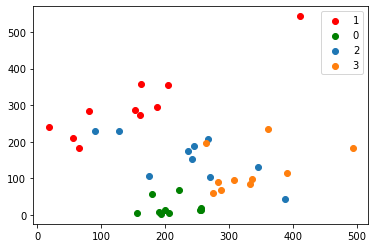

In [25]:
plot4Descriptors(zeros_im_bin_op, ones_im_bin_op, twos_im_bin_op, threes_im_bin_op)

We see, that this is not a very good way, to cluster 4 different digits. As the general shape of "2" and "3" is very similar, it is hard to distinguish them by only look at the first two fourier discriptiors. A possible solution is to use more discriptors to classify them.
